In [392]:
%matplotlib inline

from IPython.display import display
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols

In [393]:
MAX_EDIT_TIME_WORD = 20
FILTER_FIRST = False

In [394]:
bleu_scores = (
    ('src', 0, 0),                                                                           
    ('ref', 100, 100),
    ('m01', 25.35, 19.07),
    ('m02', 31.61, 22.44),
    ('m03', 33.09, 23.86),
    ('m04', 33.63, 24.42),
    ('m05', 35.22, 26.25),
    ('m06', 35.68, 26.64),
    ('m07', 36.58, 28.14),
    ('m08', 36.41, 28.84),
    ('m09', 37.40, 28.72),
    ('m10', 37.44, 28.95),
    ('m11', 37.37, 28.46),
    ('google', 37.56, 26.06),
    ('microsoft', 33.06, 26.30),
)

bleu_docs = {system: bleu_docs for system, bleu_docs, bleu_wmt in bleu_scores}
bleu_wmt = {system: bleu_wmt for system, bleu_docs, bleu_wmt in bleu_scores}

bleu_scores_df = pd.DataFrame(bleu_scores, columns=("mt_name", "bleu_docs", "bleu_wmt"))

In [395]:
df = pd.read_json("docs/memsource/data-after-phase-1.json", lines=True).merge(bleu_scores_df, on=["mt_name"])

In [396]:
# filtering step
if FILTER_FIRST:
    df = df[df["is_first"] == 0]
    
df = df[df["edit_time_word"] < MAX_EDIT_TIME_WORD]

In [397]:
df["source_words"] = df.apply(lambda r: len(r['source'].split()), 'columns')

In [398]:
df.columns

Index(['comments', 'doc_name', 'edit_time', 'edit_time_word', 'is_first',
       'is_last', 'job_uid', 'mt_name', 'provided', 'source', 'target',
       'think_time', 'think_time_word', 'tunit_id', 'user_a', 'bleu_docs',
       'bleu_wmt', 'source_words'],
      dtype='object')

In [399]:
aggregations = {
    "total_edit_time": ("edit_time", "sum"),
    "total_source_words": ("source_words", "sum"),
    "mean_edit_time": ("edit_time", "mean"),    
}

docs_df = df.groupby(["doc_name", "mt_name", "user_a"]).agg(**aggregations).reset_index()

docs_df["mean_edit_time_word"] = docs_df.apply(lambda r: r["total_edit_time"] / r["total_source_words"], 1)

docs_df

,doc_name,mt_name,user_a,total_edit_time,total_source_words,mean_edit_time,mean_edit_time_word
0,audit_i,google,3,844.165,433,49.656765,1.949573
1,audit_i,m01,6,2305.481,433,135.616529,5.324436
2,audit_i,m02,12,1400.130,433,82.360588,3.233557
3,audit_i,m03,2,478.926,433,28.172118,1.106065
4,audit_i,m04,8,1564.561,188,223.508714,8.322133
...,...,...,...,...,...,...,...
115,whistle,m10,2,302.525,219,50.420833,1.381393
116,whistle,m11,6,718.600,197,143.720000,3.647716
117,whistle,microsoft,9,1271.964,197,254.392800,6.456670
118,whistle,ref,10,683.986,219,113.997667,3.123224


In [400]:
import re

def _parse_model_params(model, variable):
    params = model.params.to_dict()
    parsed = {}
    for k, v in params.items():
        match = re.match(f"C\({variable}.*\)\[T.(.*)\]", k)
        if match:
            parsed[match.group(1)] = v
    
    return parsed    

def analyze_model(model_definition, df, variable="mt_name"):
    model = ols(model_definition, data=df)
    fitted_model = model.fit()
    display(fitted_model.summary())
    parsed_params = _parse_model_params(fitted_model, variable)
    if variable == "mt_name":
        list_labels = sorted(parsed_params, key=bleu_docs.get)
        list_bleu = [bleu_docs[k] for k in list_labels]        
        list_params = [parsed_params[k] for k in list_labels]        
        print("Correlation with docs BLEU:")
        print(stats.spearmanr(list_params, list_bleu))       
        
        plt.bar(list_labels, list_params)
        plt.show()
    print()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         edit_time_word   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     22.04
Date:                Wed, 23 Dec 2020   Prob (F-statistic):          2.74e-107
Time:                        14:03:45   Log-Likelihood:                -3535.7
No. Observations:                1367   AIC:                             7143.
Df Residuals:                    1331   BIC:                             7331.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     2.9308      0.506      5.792      0.000       1.938       3.923
C(user_a)[T.1]                                5.4209      0.511     10.609      0.000       4.419       6.423
C(user_a)[T.2]                               -2.5255      0.495     -5.103      0.000      -3.496      -1.555
C(user_a)[T.3]                               -0.3483      0.506     -0.688      0.492      -1.342       0.645
C(user_a)[T.4]                               -0.5052      0.518     -0.975      0.330      -1.522       0.512
C(user_a)[T.5]                                2.6357      0.519      5.075      0.000       1.617       3.655
C(user_a)[T.6]                                1.0443      0.532      1.964      0.050       0.001       2.087
C(user_a)[T.7]                                2.1919      0.546      4.012      0.000       1.120       3.264
C(user_a)[T.8]                                6.7944      0.643     10.573      0.000       5.534       8.055
C(user_a)[T.9]                                1.3165      0.536      2.455      0.014       0.264       2.369
C(user_a)[T.10]                              -1.3216      0.520     -2.539      0.011      -2.343      -0.301
C(user_a)[T.11]                               0.6213      0.517      1.202      0.229      -0.393       1.635
C(user_a)[T.12]                              -0.7753      0.506     -1.533      0.125      -1.767       0.217
C(user_a)[T.13]                              -1.1793      0.497     -2.372      0.018      -2.155      -0.204
C(user_a)[T.14]                               0.6934      0.487      1.424      0.155      -0.262       1.649
C(mt_name, Treatment("ref"))[T.google]        1.4759      0.515      2.867      0.004       0.466       2.486
C(mt_name, Treatment("ref"))[T.m01]           1.0659      0.529      2.014      0.044       0.028       2.104
C(mt_name, Treatment("ref"))[T.m02]           1.3433      0.513      2.616      0.009       0.336       2.351
C(mt_name, Treatment("ref"))[T.m03]           1.1219      0.500      2.245      0.025       0.142       2.102
C(mt_name, Treatment("ref"))[T.m04]           0.3745      0.551      0.679      0.497      -0.707       1.456
C(mt_name, Treatment("ref"))[T.m05]           1.6018      0.528      3.035      0.002       0.567       2.637
C(mt_name, Treatment("ref"))[T.m06]          -0.3017      0.547     -0.551      0.582      -1.376       0.772
C(mt_name, Treatment("ref"))[T.m07]           0.1106      0.524      0.211      0.833      -0.918       1.139
C(mt_name, Treatment("ref"))[T.m08]           0.8620      0.518      1.666      0.096      -0.153       1.877
C(mt_name, Treatment("ref"))[T.m09]           1.3023      0.502      2.596      0.010       0.318       2.286
C(m

Correlation with docs BLEU:
SpearmanrResult(correlation=-0.2175824175824176, pvalue=0.4549193731700327)


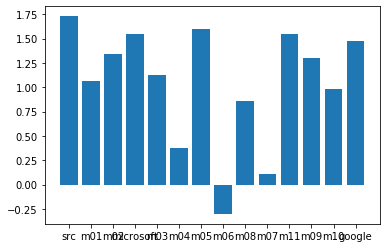

In [401]:
analyze_model('edit_time_word ~ C(user_a) + C(mt_name, Treatment("ref")) + C(doc_name)', df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     mean_edit_time_word   R-squared:                       0.803
Model:                             OLS   Adj. R-squared:                  0.720
Method:                  Least Squares   F-statistic:                     9.758
Date:                 Wed, 23 Dec 2020   Prob (F-statistic):           1.11e-17
Time:                         14:03:45   Log-Likelihood:                -194.33
No. Observations:                  120   AIC:                             460.7
Df Residuals:                       84   BIC:                             561.0
Df Model:                           35                                         
Covariance Type:             nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     2.0495      0.801      2.558      0.012       0.456       3.643
C(user_a)[T.1]                                5.2625      0.737      7.141      0.000       3.797       6.728
C(user_a)[T.2]                               -2.1485      0.745     -2.884      0.005      -3.630      -0.667
C(user_a)[T.3]                               -0.2207      0.754     -0.293      0.770      -1.720       1.279
C(user_a)[T.4]                                0.0178      0.763      0.023      0.981      -1.500       1.535
C(user_a)[T.5]                                2.7212      0.772      3.524      0.001       1.186       4.257
C(user_a)[T.6]                                1.1385      0.780      1.459      0.148      -0.413       2.690
C(user_a)[T.7]                                2.2161      0.787      2.815      0.006       0.650       3.782
C(user_a)[T.8]                                6.6724      0.787      8.474      0.000       5.107       8.238
C(user_a)[T.9]                                1.9200      0.780      2.460      0.016       0.368       3.472
C(user_a)[T.10]                              -0.9279      0.772     -1.202      0.233      -2.463       0.608
C(user_a)[T.11]                               0.8984      0.763      1.177      0.242      -0.619       2.416
C(user_a)[T.12]                              -0.2494      0.754     -0.331      0.742      -1.749       1.250
C(user_a)[T.13]                              -1.0312      0.745     -1.384      0.170      -2.513       0.450
C(user_a)[T.14]                               0.8393      0.737      1.139      0.258      -0.626       2.305
C(mt_name, Treatment("ref"))[T.google]        2.0963      0.754      2.781      0.007       0.597       3.595
C(mt_name, Treatment("ref"))[T.m01]           1.5487      0.780      1.984      0.050      -0.003       3.101
C(mt_name, Treatment("ref"))[T.m02]           1.1321      0.754      1.502      0.137      -0.367       2.631
C(mt_name, Treatment("ref"))[T.m03]           1.1596      0.745      1.557      0.123      -0.322       2.641
C(mt_name, Treatment("ref"))[T.m04]           0.8361      0.787      1.062      0.291      -0.730       2.402
C(mt_name, Treatment("ref"))[T.m05]           1.4929      0.772      1.933      0.057      -0.043       3.028
C(mt_name, Treatment("ref"))[T.m06]           0.5034      0.780      0.645      0.521      -1.049       2.055
C(mt_name, Treatment("ref"))[T.m07]           0.2807      0.772      0.364      0.717      -1.255       1.816
C(mt_name, Treatment("ref"))[T.m08]           0.5217      0.763      0.684      0.496      -0.996       2.039
C(mt_name, Treatment("ref"))[T.m09]           1.0231      0.745      1.373      0.173      -0.458     

Correlation with docs BLEU:
SpearmanrResult(correlation=-0.12967032967032965, pvalue=0.658619276321178)


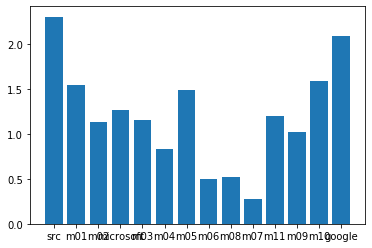

In [402]:
analyze_model('mean_edit_time_word ~ C(user_a) + C(mt_name, Treatment("ref")) + C(doc_name)', docs_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mean_edit_time   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     13.15
Date:                Wed, 23 Dec 2020   Prob (F-statistic):           8.37e-22
Time:                        14:03:46   Log-Likelihood:                -592.22
No. Observations:                 120   AIC:                             1256.
Df Residuals:                      84   BIC:                             1357.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    50.2309     22.065      2.277      0.025       6.353      94.109
C(user_a)[T.1]                              143.6496     20.295      7.078      0.000     103.291     184.009
C(user_a)[T.2]                              -52.8019     20.517     -2.574      0.012     -93.601     -12.002
C(user_a)[T.3]                                8.0981     20.763      0.390      0.698     -33.191      49.388
C(user_a)[T.4]                               13.7370     21.018      0.654      0.515     -28.060      55.534
C(user_a)[T.5]                               84.3399     21.267      3.966      0.000      42.049     126.631
C(user_a)[T.6]                               42.1308     21.493      1.960      0.053      -0.611      84.872
C(user_a)[T.7]                               61.3721     21.684      2.830      0.006      18.250     104.494
C(user_a)[T.8]                              162.9840     21.684      7.516      0.000     119.862     206.106
C(user_a)[T.9]                               48.9605     21.493      2.278      0.025       6.219      91.702
C(user_a)[T.10]                             -31.5908     21.267     -1.485      0.141     -73.882      10.700
C(user_a)[T.11]                              25.2498     21.018      1.201      0.233     -16.548      67.047
C(user_a)[T.12]                             -10.7886     20.763     -0.520      0.605     -52.078      30.501
C(user_a)[T.13]                             -33.4283     20.517     -1.629      0.107     -74.228       7.371
C(user_a)[T.14]                              25.2242     20.295      1.243      0.217     -15.135      65.583
C(mt_name, Treatment("ref"))[T.google]       33.4743     20.763      1.612      0.111      -7.815      74.764
C(mt_name, Treatment("ref"))[T.m01]          34.8833     21.493      1.623      0.108      -7.858      77.625
C(mt_name, Treatment("ref"))[T.m02]          32.6759     20.763      1.574      0.119      -8.614      73.965
C(mt_name, Treatment("ref"))[T.m03]          31.2801     20.517      1.525      0.131      -9.519      72.080
C(mt_name, Treatment("ref"))[T.m04]          22.4030     21.684      1.033      0.305     -20.719      65.525
C(mt_name, Treatment("ref"))[T.m05]          34.6543     21.267      1.630      0.107      -7.637      76.946
C(mt_name, Treatment("ref"))[T.m06]          13.6376     21.493      0.635      0.527     -29.104      56.379
C(mt_name, Treatment("ref"))[T.m07]          -5.6356     21.267     -0.265      0.792     -47.927      36.656
C(mt_name, Treatment("ref"))[T.m08]          16.1480     21.018      0.768      0.444     -25.649      57.945
C(mt_name, Treatment("ref"))[T.m09]          43.8347     20.517      2.137      0.036       3.035      84.634
C(m

Correlation with docs BLEU:
SpearmanrResult(correlation=-0.42857142857142855, pvalue=0.1262738881593127)


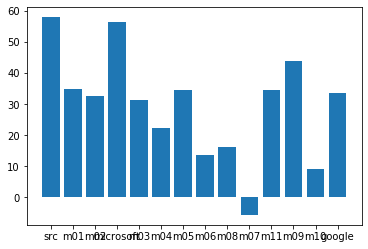

In [403]:
analyze_model('mean_edit_time ~ C(user_a) + C(mt_name, Treatment("ref")) + C(doc_name)', docs_df)